In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


loan = pd.read_csv('accepted_2007_to_2018Q4.csv')

return_number = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

def convert_date(d):
    try:
        return datetime.date(year=int(d[4:]), month=return_number[d[:3]], day=1)
    except:
        pass

loan['issue_d'] = loan['issue_d'].apply(convert_date)
loan['earliest_cr_line'] = loan['earliest_cr_line'].apply(convert_date)

loan = loan[loan.issue_d < datetime.date(2015,7,1)]
loan = loan[loan.issue_d >= datetime.date(2010,1,1)]

loan = loan[loan.term == ' 36 months']

loan['earliest_cr_line'] = loan.apply(lambda x: (x['issue_d'] - x['earliest_cr_line']).days, axis=1)

loan = loan[(loan.loan_status == 'Fully Paid') | (loan.loan_status == 'Charged Off')]

loan = loan[loan.annual_inc < 1000000]

loan['ln_annual_inc'] = np.log(loan.annual_inc)

loan = loan[loan.revol_util < 150]
loan['ln_revol_bal'] = np.log(loan.revol_bal+1)

loan['ln_earliest_cr_line'] = np.log(loan.earliest_cr_line)

loan['ln_open_acc'] = np.log(loan.open_acc)

loan.rename(columns = {'delinq_2yrs': 'num_delinq_2yrs'}, inplace=True)
loan['delinq_2yrs'] = (loan['num_delinq_2yrs'] >= 1)

loan.rename(columns = {'pub_rec': 'num_pub_rec'}, inplace=True)
loan['pub_rec'] = (loan['num_pub_rec'] >= 1)

loan.rename(columns = {'inq_last_6mths': 'num_inq_last_6mths'}, inplace=True)
loan['inq_last_6mths'] = (loan['num_inq_last_6mths'] >= 1)

loan['target'] = (loan['loan_status'] == 'Fully Paid')

In [2]:
col_list = ['loan_amnt', 'int_rate', 'ln_annual_inc', 'dti', 'fico_range_high', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'num_inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'ln_open_acc', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']


In [3]:
# We will use 2010-2013 to tune our models, and save data from 2014 and the first 
# 6 months of 2015 for walk-forward testing

train = loan[loan.issue_d < datetime.date(2014, 1, 1)]
test = loan[(loan.issue_d >= datetime.date(2014, 1, 1)) & (loan.issue_d < datetime.date(2015, 7, 1))]


In [4]:
y = train['target']
X1 = train[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2 = pd.concat([X1, train.int_rate, pd.get_dummies(train.grade)], axis=1)
X3 = pd.concat([X1, train.int_rate, pd.get_dummies(train.sub_grade)], axis=1)


In [5]:
X1_test = test[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.grade)], axis=1)
X3_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.sub_grade)], axis=1)
y_test = test['target']

In [6]:
from sklearn.model_selection import RandomizedSearchCV


In [7]:
def returns_by_grade(metric, grade, returns, thresh = [80, 90, 95]):
    for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        
        cutoffs = [np.percentile(metric[grade == letter], q=x) for x in thresh]
        
        print('--------------  ' + letter + '  --------------')
        print('')
    
        print('Naive Returns:             {}%'.format(round(returns[grade==letter].mean()*100, 2)))
        print('')
        
        for c in range(len(thresh)):
            print('{} Percent Cutoff:         {}%'.format(thresh[c], round(returns[(grade == letter) & (metric >= cutoffs[c])].mean()*100,2)))
            
        print('')
        
#returns_by_grade(test.pred2, test.grade, test.pct_return)


In [11]:
from sklearn.svm import SVC

svc1 = SVC(probability=True)

svc1 = svc1.fit(X2, y)

test['pred1'] = svc1.predict_proba(X2_test)

test[['grade', 'int_rate', 'pred1', 'target']]

,grade,int_rate,pred1,target
235833,B,11.53,0.124245,True
236722,A,7.89,0.124340,True
236789,B,8.18,0.124445,False
236812,D,17.57,0.124313,False
237037,E,18.25,0.124185,True
...,...,...,...,...
1352681,A,7.90,0.124246,False
1352682,D,18.25,0.123405,True
1352683,B,13.53,0.123426,True
1352686,A,7.90,0.123542,True


In [13]:
test['pred1'] = 1 - test['pred1']

In [14]:
test[['grade', 'int_rate', 'pred1', 'target']]

,grade,int_rate,pred1,target
235833,B,11.53,0.875755,True
236722,A,7.89,0.875660,True
236789,B,8.18,0.875555,False
236812,D,17.57,0.875687,False
237037,E,18.25,0.875815,True
...,...,...,...,...
1352681,A,7.90,0.875754,False
1352682,D,18.25,0.876595,True
1352683,B,13.53,0.876574,True
1352686,A,7.90,0.876458,True


In [15]:
from sklearn.metrics import roc_auc_score


roc_auc_score(test.target, test.pred1)

0.4817199256977774

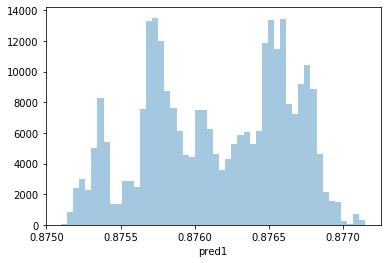

In [16]:
sns.distplot(test.pred1, kde=False)

In [17]:
def returns_by_grade(metric, grade, returns, thresh = [80, 90, 95]):
    for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        
        cutoffs = [np.percentile(metric[grade == letter], q=x) for x in thresh]
        
        print('--------------  ' + letter + '  --------------')
        print('')
    
        print('Naive Returns:             {}%'.format(round(returns[grade==letter].mean()*100, 2)))
        print('')
        
        for c in range(len(thresh)):
            print('{} Percent Cutoff:         {}%'.format(thresh[c], round(returns[(grade == letter) & (metric >= cutoffs[c])].mean()*100,2)))
            
        print('')


test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt

returns_by_grade(test.pred1, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         7.54%
90 Percent Cutoff:         7.53%
95 Percent Cutoff:         7.82%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         9.02%
90 Percent Cutoff:         8.89%
95 Percent Cutoff:         9.24%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         8.61%
90 Percent Cutoff:         8.61%
95 Percent Cutoff:         9.08%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         8.06%
90 Percent Cutoff:         7.58%
95 Percent Cutoff:         8.41%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         5.37%
90 Percent Cutoff:         7.18%
95 Percent Cutoff:         7.16%

--------------  F  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         7.53%
90 Percent Cutoff:         5.87%
95 Percent Cutoff:   

In [21]:
pd.DataFrame(svc1.support_vectors_[0:5])

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,9000.0,10.308953,10.08,714.0,0.0,0.0,7.937375,1.0,1.0,1.386294,...,91.7,9.0,13.49,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,10000.0,11.512925,7.06,724.0,0.0,0.0,8.925188,1.0,2.0,2.639057,...,55.5,29.0,10.65,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,21000.0,11.561716,13.22,709.0,0.0,0.0,9.261984,0.0,0.0,1.945910,...,90.3,38.0,12.42,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,6000.0,11.238489,2.40,694.0,0.0,0.0,8.251925,1.0,1.0,1.945910,...,29.7,7.0,11.71,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,15000.0,11.002100,15.22,699.0,0.0,0.0,8.000685,1.0,1.0,1.945910,...,57.6,11.0,14.27,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'C': [.1, .25, .5, 1, 2, 5, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'degree': [2,3]
}

svc2 = SVC(probability=True)
svc2_random = RandomizedSearchCV(estimator=svc2, param_distributions=param_grid, n_iter=40, random_state=27)
svc2_random.fit(X2, y)